# Import packages

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings 
warnings.filterwarnings("ignore")

# Import data

In [2]:
df = pd.read_csv('../data/base_modelis_pass_det.csv',sep = ';')

# Dataviz rapide

In [3]:
df.isna().sum()

cd_op                      0
date_entree_defaut         0
date_sortie_defaut    315468
arrete                     0
fl_pass_DET                0
                       ...  
PTG                    29088
AGE_EMP1                   0
AGE_EMP2              134311
TX_ENDET               19935
MT_REST_VIVRE          25373
Length: 90, dtype: int64

In [4]:
df.head(20)

,cd_op,date_entree_defaut,date_sortie_defaut,arrete,fl_pass_DET,nb_prt,DT_MEP_OPE,CD_NAT_EMP1,CD_NAT_EMP2,ANC_BANC_MAX_PFI,...,EAD_1an_avant_def,LTVnonactu_1an_avant_def,dls_ges_def,AMI,EXE,PTG,AGE_EMP1,AGE_EMP2,TX_ENDET,MT_REST_VIVRE
0,I860708600,16/01/17,NaN,31/01/17,0,1,15SEP1986:00:00:00.000,NaN,NaN,NaN,...,1121.38,NaN,0,NaN,NaN,NaN,74,78.0,NaN,NaN
1,I860708600,16/01/17,NaN,28/02/17,0,1,15SEP1986:00:00:00.000,NaN,NaN,NaN,...,1121.38,NaN,1,NaN,NaN,NaN,75,78.0,NaN,NaN
2,I860708600,16/01/17,NaN,31/03/17,0,1,15SEP1986:00:00:00.000,NaN,NaN,NaN,...,1121.38,NaN,2,NaN,NaN,NaN,75,78.0,NaN,NaN
3,I860708600,16/01/17,NaN,30/04/17,0,1,15SEP1986:00:00:00.000,NaN,NaN,NaN,...,1121.38,NaN,3,NaN,NaN,NaN,75,78.0,NaN,NaN
4,I860708600,16/01/17,NaN,31/05/17,0,1,15SEP1986:00:00:00.000,NaN,NaN,NaN,...,1121.38,NaN,4,NaN,NaN,NaN,75,78.0,NaN,NaN
5,I860708600,16/01/17,NaN,30/06/17,0,1,15SEP1986:00:00:00.000,NaN,NaN,NaN,...,1121.38,NaN,5,NaN,NaN,NaN,75,78.0,NaN,NaN
6,I860708600,16/01/17,NaN,31/07/17,0,1,15SEP1986:00:00:00.000,NaN,NaN,NaN,...,1121.38,NaN,6,NaN,NaN,NaN,75,79.0,NaN,NaN
7,I860708600,16/01/17,NaN,31/08/17,0,1,15SEP1986:00:00:00.000,NaN,NaN,NaN,...,1121.38,NaN,7,NaN,NaN,NaN,75,79.0,NaN,NaN
8,I860708600,16/01/17,NaN,30/09/17,0,1,15SEP1986:00:00:00.000,NaN,NaN,NaN,...,1121.38,NaN,8,NaN,NaN,NaN,75,79.0,NaN,NaN
9,I860708600,16/01/17,NaN,31/10/17,0,1,15SEP1986:00:00:00.000,NaN,NaN,NaN,...,1121.38,NaN,9,NaN,NaN,NaN,75,79.0,NaN,NaN


# Data treatment

In [3]:
df['date_entree_defaut'] = pd.to_datetime(df['date_entree_defaut'])

In [4]:
df['arrete'] = pd.to_datetime(df['arrete'])

In [5]:
df_validation = df[df['arrete']>"2020-12-30"]

On split les données en un ensemble de train et un de test, toutes les données anterieures 2021 seront dans le train et le reste dans le test

In [24]:
data = df[df['arrete']<"2020-12-30"]

On va garder une seule ligne par identifiant client, la plus récente pour chaque client, pour cela on doit trier par la date au sein de chaque groupe 'cd_op'

In [28]:
data = data.groupby('cd_op').apply(lambda x: x.sort_values(by='arrete', ascending=False))

Ensuite on ne va garder que la dernière occurence de chaque cd_op pour le logit

In [31]:
data_logit = data.drop_duplicates(subset = 'cd_op', keep = 'first')

#### On va récupérer les colonnes contenant bcp de NaN dans le jeu de test pour les retirer aussi du train_test

In [33]:
df_validation = df_validation.groupby('cd_op').apply(lambda x: x.sort_values(by='arrete', ascending=False))

condition = df_validation.drop_duplicates(subset='cd_op', keep='first').isna().sum() > 1200
df_filtered = df_validation.loc[:, condition]

In [13]:
df_filtered.columns

Index(['date_sortie_defaut', 'CD_NAT_EMP2', 'MT_CHA_CSM_REV', 'MT_CHA_IMP',
       'MT_CHA_PIP', 'MT_CHA_PIV', 'CD_CSP_EMP2', 'CD_SITFAM_EMP2',
       'NB_RP_HOP', 'NB_RS_HOP', 'NB_LO_HOP', 'dtSRT1st', 'dtHJD_def',
       'dtHJD_prov', 'dt_arr_last_enc_ope', 'dt_arr_1st_enc_ope',
       'valeur_bien_afr', 'mt_inscrip_devant_CL_afr', 'dispo_HP_afr',
       'LTV_actu', 'LTVnonactu_1an_avant_def', 'AMI', 'EXE', 'PTG',
       'AGE_EMP2'],
      dtype='object')

In [34]:
liste_col_a_retirer = ['ANC_BANC_MAX_PFI','MT_CHA_CSM_REV','MT_CHA_IMP','MT_CHA_PIP','MT_CHA_PIV','NB_RP_HOP','NB_RS_HOP','NB_LO_HOP',
                        'dtSRT1st','valeur_bien_afr','mt_inscrip_devant_CL_afr','dispo_HP_afr','MT_CHG_MSL','mt_rev_dispo','LTV_actu','LTVnonactu_1an_avant_def','AMI','EXE','PTG','AGE_EMP2','CD_MTF_ENE_CTX','niv_gravite_mtf_dne','niv_gravite_mtf_dfs','MT_CHG_MSL','mt_rev_dispo','TX_ENDET','MT_REST_VIVRE','fam_PCD','mt_dec_cum_IMP_tot',
                       'date_sortie_defaut', 'CD_NAT_EMP2', 'MT_CHA_CSM_REV', 'MT_CHA_IMP','MT_CHA_PIP', 'MT_CHA_PIV', 'CD_CSP_EMP2', 'CD_SITFAM_EMP2','NB_RP_HOP', 'NB_RS_HOP', 'NB_LO_HOP', 'dtSRT1st', 'dtHJD_def','dtHJD_prov', 'dt_arr_last_enc_ope', 'dt_arr_1st_enc_ope','valeur_bien_afr', 'mt_inscrip_devant_CL_afr', 'dispo_HP_afr','LTV_actu', 'LTVnonactu_1an_avant_def', 'AMI', 'EXE', 'PTG','AGE_EMP2','cum_dec','cum_rec']
# cum_dec enorme pouvoir predictif, demander si il faut la retirer ou non

In [35]:
liste_col_a_retirer = set(liste_col_a_retirer) # pour supprimer les doublons

In [36]:
liste_col_a_retirer = list(liste_col_a_retirer)

# 01-Logit simple

In [37]:
data_logit['fl_pass_DET'].value_counts()

fl_pass_DET
0    12809
1     5006
Name: count, dtype: int64

In [38]:
# Sélectionner les données
X = data.drop(columns=liste_col_a_retirer) # On drop les var qui ont trop de NaN
X = X.select_dtypes(include = 'number')
X.dropna(inplace = True)

y = X['fl_pass_DET']

X.drop(columns = 'fl_pass_DET', inplace = True)


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_prob)

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)


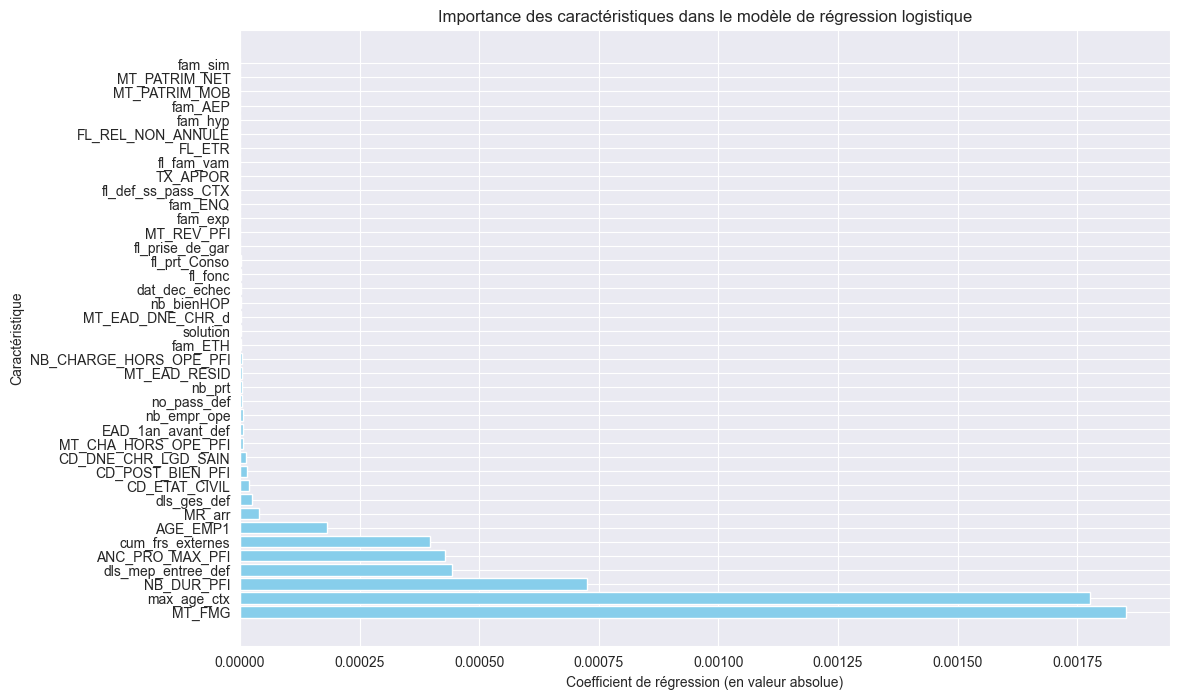

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Obtenir les coefficients du modèle
coefficients = model.coef_[0]

# Obtenir les noms des caractéristiques
feature_names = X.columns

# Créer un DataFrame avec les noms des caractéristiques et leurs coefficients
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Trier le DataFrame par coefficient en valeur absolue pour avoir une visualisation plus claire
feature_importance_df['Abs_Coefficient'] = np.abs(feature_importance_df['Coefficient'])
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

# Tracer le graphique des importances des caractéristiques
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Abs_Coefficient'], color='skyblue')
plt.xlabel('Coefficient de régression (en valeur absolue)')
plt.ylabel('Caractéristique')
plt.title('Importance des caractéristiques dans le modèle de régression logistique')
plt.show()


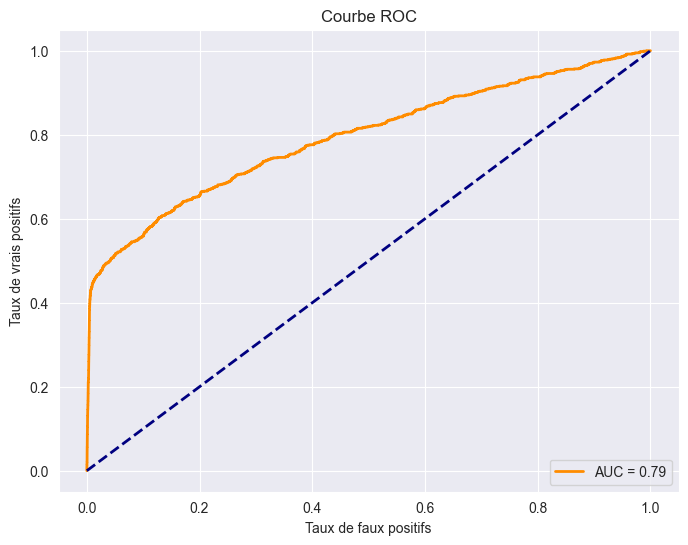

In [42]:
from sklearn.metrics import roc_curve, auc
# Faire des prédictions de probabilités
y_prob = model.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculer l'AUC
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

# Test pour voir la variable parasite

In [43]:
# Sélectionner les données
X = data[['MT_FMG','max_age_ctx','cum_frs_externes','dls_mep_entree_def','NB_DUR_PFI','ANC_PRO_MAX_PFI','cum_dec','cum_rec','AGE_EMP1','MT_EAD_RESID','MR_arr','dls_ges_def','MT_EAD_DNE_CHR_d','MT_CHA_HORS_OPE_PFI','CD_POST_BIEN_PFI','EAD_1an_avant_def','CD_ETAT_CIVIL','CD_DNE_CHR_LGD_SAIN','fl_pass_DET']] # On drop les var qui ont trop de NaN


X.dropna(inplace = True)

y = X['fl_pass_DET']

X.drop(columns = 'fl_pass_DET', inplace = True)


In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Supposons que X sont vos caractéristiques et y est votre variable cible
# Assurez-vous que X et y sont des DataFrames ou des tableaux NumPy

# Créer une liste pour stocker les résultats
results = []

# Boucle sur chaque variable
for variable in X.columns:
    # Sélectionner la variable courante
    X_variable = X[[variable]]
    
    # Diviser les données
    X_train, X_test, y_train, y_test = train_test_split(X_variable, y, test_size=0.2, random_state=42)
    
    # Créer et entraîner le modèle de régression logistique
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Faire des prédictions de probabilités
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculer l'AUC
    auc = roc_auc_score(y_test, y_prob)
    
    # Ajouter les résultats à la liste
    results.append({'Variable': variable, 'AUC': auc})

# Créer un DataFrame à partir de la liste de résultats
auc_df = pd.DataFrame(results)

# Afficher les résultats
print(auc_df)


               Variable       AUC
0                MT_FMG  0.503846
1           max_age_ctx  0.508034
2      cum_frs_externes  0.653261
3    dls_mep_entree_def  0.491156
4            NB_DUR_PFI  0.482766
5       ANC_PRO_MAX_PFI  0.525001
6               cum_dec  0.981448
7               cum_rec  0.560703
8              AGE_EMP1  0.492890
9          MT_EAD_RESID  0.506675
10               MR_arr  0.865330
11          dls_ges_def  0.632553
12     MT_EAD_DNE_CHR_d  0.493864
13  MT_CHA_HORS_OPE_PFI  0.533092
14     CD_POST_BIEN_PFI  0.488512
15    EAD_1an_avant_def  0.500092
16        CD_ETAT_CIVIL  0.513423
17  CD_DNE_CHR_LGD_SAIN  0.508619
